In [54]:
!python -m pip install langchain langchain-core langchain-community langchain-experimental --quiet
!python -m pip install langchain-openai --quiet
!python -m pip install langgraph
!python -m pip install mlflow openai dspy litellm textstat evaluate --quiet


In [2]:
selected_model = 'gpt4o'

In [3]:
from dotenv import load_dotenv
load_dotenv()


True

In [4]:
import os
import mlflow
from openai import AzureOpenAI

from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import TypedDict
from langgraph.graph import StateGraph,START


class llmState(TypedDict):
    name:str
    code:str
    news:str
    response:str

parser = StrOutputParser()
model = AzureChatOpenAI(model=selected_model)

mlflow.set_tracking_uri("http://20.75.92.162:5000/")
print(mlflow.__version__)

3.3.2


In [ ]:
import requests,json
def get_current_market_info(state:llmState)->llmState:
    api_key="B2RLNMRRBYYP1WNC"
    url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={state.get('code')}&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    if(data):
        return {"news":data}

In [6]:
def get_company_symbol(state:llmState)->llmState:
    """ can be used to get/fetch  Company symbol based on company name """
    apikey="2MXO372OJXFFEAQV"
    url = f"https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={state.get('name').lower()}&apikey={apikey}"
    response = requests.get(url)
    data = response.json()
    if(data['bestMatches']):
        #print(data['bestMatches'])
        return {"code":data['bestMatches'][1]['1. symbol']}

    

In [7]:
def get_llm_response(state:llmState)->llmState:
     """ can be used to get JSON information based on news provided """
     generate_promt = ChatPromptTemplate([("system","Analyse the news provided and give me Classify sentiment in JSON response."),
                                          ("user","{news}")])
     parsed_data = model.invoke(generate_promt.invoke({"news":state.get('news')}))
     response = parser.invoke(parsed_data)
     return {"response":response}

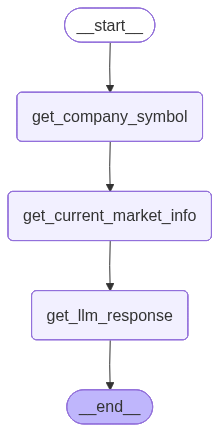

In [8]:
builder = StateGraph(llmState)
builder.add_sequence([get_company_symbol,get_current_market_info,get_llm_response])
builder.add_edge(START,"get_company_symbol")

graph = builder.compile()
graph

In [9]:
promt = {"name":"APPLE"}
result = graph.invoke(promt)
print(result['response'])

{'items': '50', 'sentiment_score_definition': 'x <= -0.35: Bearish; -0.35 < x <= -0.15: Somewhat-Bearish; -0.15 < x < 0.15: Neutral; 0.15 <= x < 0.35: Somewhat_Bullish; x >= 0.35: Bullish', 'relevance_score_definition': '0 < x <= 1, with a higher score indicating higher relevance.', 'feed': [{'title': "Apple's iPhone 17 Rollout Tanked the Stock. Time to Buy the Dip?", 'url': 'https://www.fool.com/investing/2025/09/16/apples-iphone-17-rollout-tanked-the-stock-time-to/', 'time_published': '20250917T014100', 'authors': ['John Bromels'], 'summary': "Wall Street is overlooking a key indicator that may send Apple's sales soaring.", 'banner_image': 'https://g.foolcdn.com/image/?url=https%3A%2F%2Fg.foolcdn.com%2Feditorial%2Fimages%2F833488%2Fgettyimages-1365884395-1200x800-5b2df79.jpg&op=resize&w=700', 'source': 'Motley Fool', 'category_within_source': 'n/a', 'source_domain': 'www.fool.com', 'topics': [{'topic': 'Earnings', 'relevance_score': '0.614606'}, {'topic': 'Technology', 'relevance_sco

In [10]:
prompt = mlflow.register_prompt(
    name="krishnateja-assignment-prompt",
    template=promt,
    # Optional: Provide a commit message to describe the changes
    commit_message="Initial commit",
)
print(f"Created prompt '{prompt.name}' (version {prompt.version})")

/tmp/ipykernel_5311/1143657237.py:1: FutureWarning: The `mlflow.register_prompt` API is moved to the `mlflow.genai` namespace. Please use `mlflow.genai.register_prompt` instead. The original API will be removed in the future release.
  prompt = mlflow.register_prompt(
2025/09/17 09:29:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for prompt version to finish creation. Prompt name: krishnateja-assignment-prompt, version 2


Created prompt 'krishnateja-assignment-prompt' (version 2)


In [11]:
promt2 = {"name":"Microsoft"}
result = graph.invoke(promt2)
print(result['response'])

{'items': '50', 'sentiment_score_definition': 'x <= -0.35: Bearish; -0.35 < x <= -0.15: Somewhat-Bearish; -0.15 < x < 0.15: Neutral; 0.15 <= x < 0.35: Somewhat_Bullish; x >= 0.35: Bullish', 'relevance_score_definition': '0 < x <= 1, with a higher score indicating higher relevance.', 'feed': [{'title': 'The Smartest Artificial Intelligence  ( AI )  Stocks to Buy With $1,000', 'url': 'https://www.fool.com/investing/2025/09/16/the-smartest-artificial-intelligence-ai-stocks-to/', 'time_published': '20250917T003500', 'authors': ['Adam Spatacco'], 'summary': 'Investors can start buying shares in several leading artificial intelligence (AI) stocks with a modest sum of just $1,000.', 'banner_image': 'https://g.foolcdn.com/image/?url=https%3A%2F%2Fg.foolcdn.com%2Feditorial%2Fimages%2F833063%2Fgettyimages-1189081858.jpg&op=resize&w=700', 'source': 'Motley Fool', 'category_within_source': 'n/a', 'source_domain': 'www.fool.com', 'topics': [{'topic': 'Retail & Wholesale', 'relevance_score': '0.3333

In [12]:
prompt = mlflow.register_prompt(
    name="krishnateja-assignment-prompt",
    template=promt2,
    # Optional: Provide a commit message to describe the changes
    commit_message="Initial commit",
)
print(f"Created prompt '{prompt.name}' (version {prompt.version})")

/tmp/ipykernel_5311/27330924.py:1: FutureWarning: The `mlflow.register_prompt` API is moved to the `mlflow.genai` namespace. Please use `mlflow.genai.register_prompt` instead. The original API will be removed in the future release.
  prompt = mlflow.register_prompt(
2025/09/17 09:31:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for prompt version to finish creation. Prompt name: krishnateja-assignment-prompt, version 3


Created prompt 'krishnateja-assignment-prompt' (version 3)


In [13]:
import pandas as pd

eval_data = pd.DataFrame(
    {
        "inputs": [promt['name']],
        "targets": [
            result['response']
        ],
    }
)

In [14]:
client = AzureOpenAI()

def predict(data: pd.DataFrame) -> list[str]:
    predictions = []
    prompt = mlflow.genai.load_prompt("prompts:/krishnateja-assignment-prompt/2")

    for _, row in data.iterrows():
        # Fill in variables in the prompt template
        content = prompt.format(sentences=row["inputs"], num_sentences=1)
        completion = client.chat.completions.create(
            model="gpt4o",
            messages=[{"role": "user", "content": content}],
            temperature=0.1,
        )
        predictions.append(completion.choices[0].message.content)

    return predictions

In [15]:
mlflow.set_experiment('krishna-assignment-prompt-evaluation')

2025/09/17 09:31:53 INFO mlflow.tracking.fluent: Experiment with name 'krishna-assignment-prompt-evaluation' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/356933365722255456', creation_time=1758081713332, experiment_id='356933365722255456', last_update_time=1758081713332, lifecycle_stage='active', name='krishna-assignment-prompt-evaluation', tags={}>

In [16]:
from dotenv import load_dotenv
load_dotenv()

True

In [17]:

with mlflow.start_run(run_name="krishna-assignment-prompt-evaluation"):
    mlflow.log_param("model", "gpt-4o-mini")
    mlflow.log_param("temperature", 0.1)

    results = mlflow.evaluate(
        model=predict,
        data=eval_data,
        targets="targets",
        extra_metrics=[
            mlflow.metrics.latency(),
            mlflow.metrics.genai.answer_relevance(model="openai:/gpt-4o-mini"),
            mlflow.metrics.genai.answer_similarity(model="openai:/gpt-4o-mini"),
            mlflow.metrics.ari_grade_level(),
            mlflow.metrics.flesch_kincaid_grade_level()
        ],

    )

2025/09/17 09:32:15 INFO mlflow.models.evaluation.utils.trace: Auto tracing is temporarily enabled during the model evaluation for computing some metrics and debugging. To disable tracing, call `mlflow.autolog(disable=True)`.
2025/09/17 09:32:19 INFO mlflow.models.evaluation.evaluators.default: Computing model predictions.
2025/09/17 09:32:25 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

🏃 View run krishna-assignment-prompt-evaluation at: http://20.75.92.162:5000/#/experiments/356933365722255456/runs/3220872c05cd486cb8a332c08844bf65
🧪 View experiment at: http://20.75.92.162:5000/#/experiments/356933365722255456


Trace(trace_id=tr-87cf261409f916b0cec2838cb4e2acd7)